In [58]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from itertools import product
from tqdm import tqdm_notebook

import datetime as dt
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

from sklearn.linear_model import LinearRegression, LassoCV

from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.util import to_pandas

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

EDA

In [59]:
#get data

data = pd.read_csv('/home/dataengineer/OTUS_ML/data/Metro_Interstate_Traffic_Volume.csv', index_col=['date_time'], parse_dates=['date_time'])
data = data.drop(['rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description'], axis=1)
data

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,None,288.28,5545
2012-10-02 10:00:00,None,289.36,4516
2012-10-02 11:00:00,None,289.58,4767
2012-10-02 12:00:00,None,290.13,5026
2012-10-02 13:00:00,None,291.14,4918
...,...,...,...
2018-09-30 19:00:00,None,283.45,3543
2018-09-30 20:00:00,None,282.76,2781
2018-09-30 21:00:00,None,282.73,2159


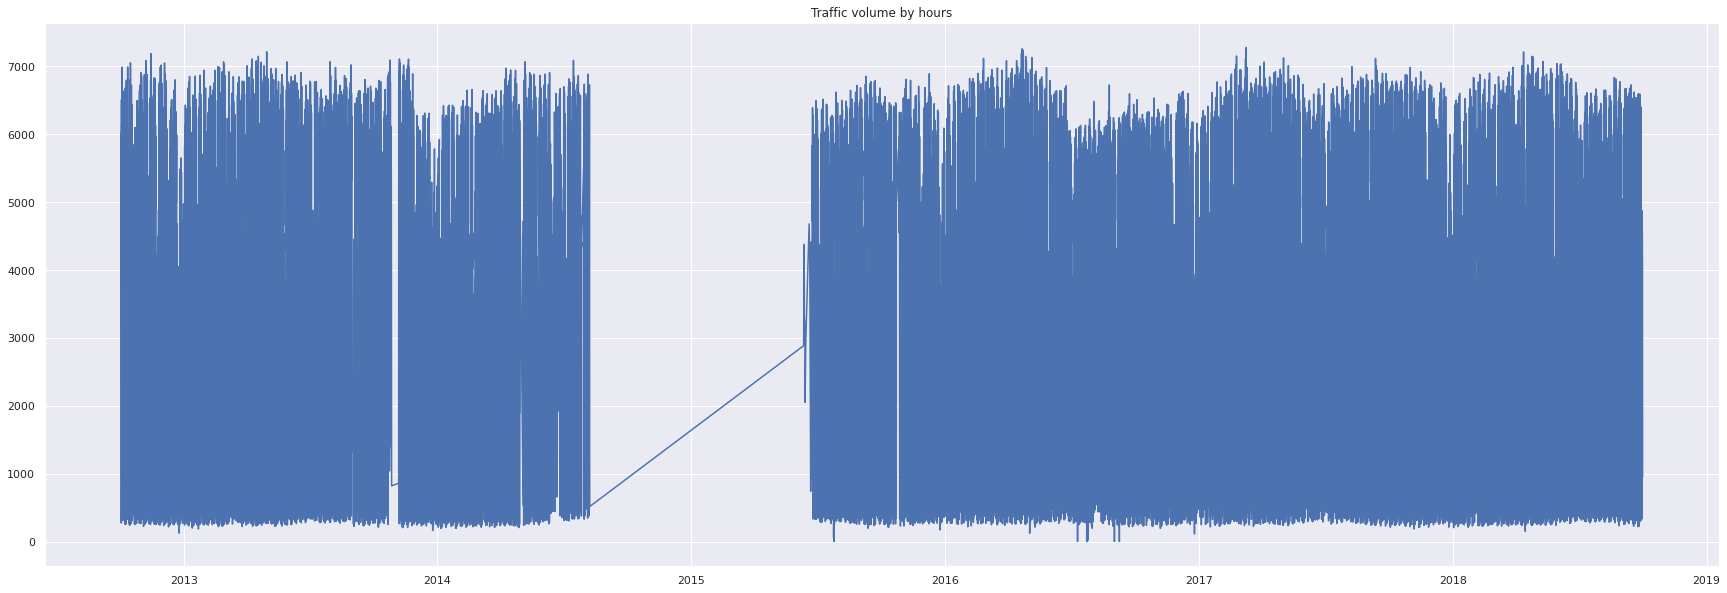

In [60]:
plt.figure(figsize=(30, 10))
plt.plot(data.traffic_volume)
plt.title('Traffic volume by hours')
plt.grid(True)
plt.show()

In [61]:
#check dublicates

data_check_dublicates = data.groupby(['date_time']).count()
data_check_dublicates.sort_values(by = ['traffic_volume'], ascending=False)

,holiday,temp,traffic_volume
date_time,,,
2013-05-19 10:00:00,6,6,6
2013-04-18 22:00:00,6,6,6
2012-12-16 21:00:00,5,5,5
2012-10-25 15:00:00,5,5,5
2013-12-16 10:00:00,5,5,5
...,...,...,...
2015-07-03 20:00:00,1,1,1
2015-07-03 21:00:00,1,1,1
2015-07-03 22:00:00,1,1,1


In [62]:
#drop duplicates

data = data[~data.index.duplicated(keep='first')]
data.shape

(40575, 3)

In [63]:
#select data > limit

dt_limit = dt.datetime(2017, 9, 30, 0, 0, 0, 0)

data = data[data.index >= dt_limit]

In [64]:
#check data gaps

data_ts = data[['traffic_volume']]

data_ts['datetime_current'] = data_ts.index.astype('int64')
data_ts["datetime_shifted"] = data_ts.datetime_current.shift(periods=1, fill_value = dt_limit.timestamp()*1000000000)
data_ts['diff_h'] = (data_ts.datetime_current - data_ts.datetime_shifted) / 3600000000000

data_ts[data_ts['diff_h'] > 1]

,traffic_volume,datetime_current,datetime_shifted,diff_h
date_time,,,,
2017-09-30 00:00:00,1265,1506729600000000000,1.506719e+18,3.0
2017-11-08 03:00:00,373,1510110000000000000,1.510103e+18,2.0
2017-11-09 03:00:00,361,1510196400000000000,1.510189e+18,2.0
2017-11-11 03:00:00,541,1510369200000000000,1.510362e+18,2.0
2017-11-15 03:00:00,354,1510714800000000000,1.510708e+18,2.0
2017-12-05 18:00:00,3936,1512496800000000000,1.512482e+18,4.0
2017-12-23 03:00:00,391,1513998000000000000,1.513991e+18,2.0
2018-01-18 03:00:00,366,1516244400000000000,1.516237e+18,2.0
2018-01-31 03:00:00,376,1517367600000000000,1.517360e+18,2.0


In [65]:
#fill gaps - get time series

data_ts['datetime'] = data_ts.apply(lambda row: list(pd.date_range(row.datetime_shifted + 3600000000000, row.datetime_current, freq='1H')), axis = 1)
data_ts = data_ts.explode('datetime')

data_ts['datetime'] = data_ts['datetime'].fillna(data_ts.index.to_series())
data_ts = data_ts[['datetime']]

In [66]:
#fill gaps - interpolate

data = pd.merge(data_ts, data, left_on='datetime', right_on='date_time', how='left')

data['holiday'] = data.holiday.interpolate(method='pad')
data['temp'] = data.temp.interpolate(method='linear')
data['traffic_volume'] = data.traffic_volume.interpolate(method='linear')

data = data.set_index('datetime')
data = data[data.index >= dt_limit]

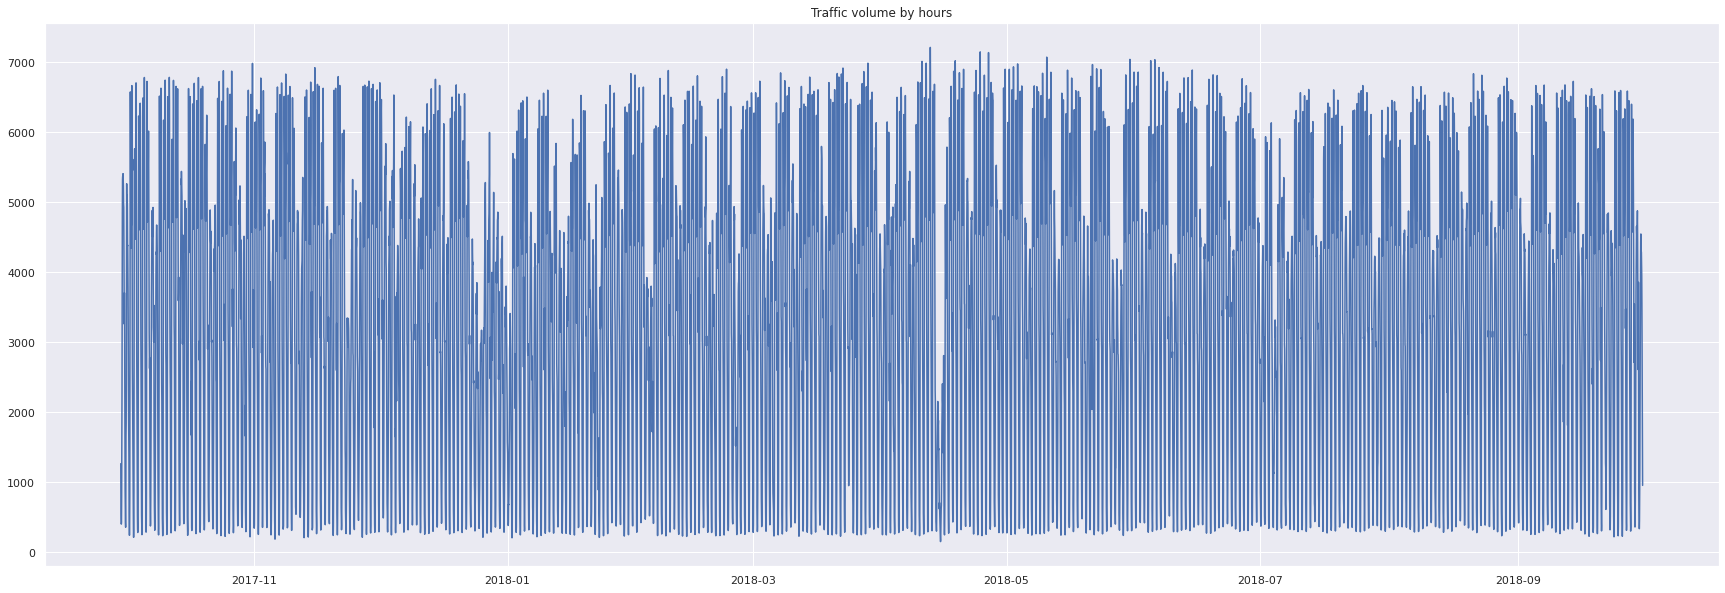

In [67]:
plt.figure(figsize=(30, 10))
plt.plot(data.traffic_volume)
plt.title('Traffic volume by hours')
plt.grid(True)
plt.show()

PREPROCESSING AND FEATURE ENGINEERING

In [68]:
#one-hot coding

data['holiday'] = data.holiday.str.replace(" ", "")
data = pd.get_dummies(data, columns=['holiday'])

In [69]:
#features from index

data['weekday'] = data.index.weekday
data['hour'] = data.index.hour
data['is_weekend'] = data.weekday.isin([5,6])*1

In [70]:
#features from shifted values

data["traffic_volume_lag_1h"] = data.traffic_volume.shift(periods=1)
data["traffic_volume_lag_24h"] = data.traffic_volume.shift(periods=24)
data = data[data.index >= dt_limit + timedelta(days=1)]

In [71]:
data

,temp,traffic_volume,holiday_ChristmasDay,holiday_ColumbusDay,holiday_IndependenceDay,holiday_LaborDay,holiday_MartinLutherKingJrDay,holiday_MemorialDay,holiday_NewYearsDay,holiday_None,holiday_StateFair,holiday_ThanksgivingDay,holiday_VeteransDay,holiday_WashingtonsBirthday,weekday,hour,is_weekend,traffic_volume_lag_1h,traffic_volume_lag_24h
datetime,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:00,288.93,1447.0,0,0,0,0,0,0,0,1,0,0,0,0,6,0,1,2517.0,1265.0
2017-10-01 01:00:00,288.55,894.0,0,0,0,0,0,0,0,1,0,0,0,0,6,1,1,1447.0,744.0
2017-10-01 02:00:00,288.44,617.0,0,0,0,0,0,0,0,1,0,0,0,0,6,2,1,894.0,552.0
2017-10-01 03:00:00,288.29,426.0,0,0,0,0,0,0,0,1,0,0,0,0,6,3,1,617.0,401.0
2017-10-01 04:00:00,287.65,356.0,0,0,0,0,0,0,0,1,0,0,0,0,6,4,1,426.0,432.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,283.45,3543.0,0,0,0,0,0,0,0,1,0,0,0,0,6,19,1,3947.0,3818.0
2018-09-30 20:00:00,282.76,2781.0,0,0,0,0,0,0,0,1,0,0,0,0,6,20,1,3543.0,3338.0
2018-09-30 21:00:00,282.73,2159.0,0,0,0,0,0,0,0,1,0,0,0,0,6,21,1,2781.0,2950.0


In [72]:
#split to train and test for baseline model

dt_train_test_limit = dt.datetime(2018, 9, 16, 0, 0, 0, 0)

data_train = data[data.index < dt_train_test_limit]
data_test = data[data.index >= dt_train_test_limit]

In [73]:
#split to train and test for regression models

data_m = pd.get_dummies(data, columns=['weekday', 'hour'])

data_m_train = data_m[data_m.index < dt_train_test_limit]
data_m_test = data_m[data_m.index >= dt_train_test_limit]

X_train = data_m_train.drop(['traffic_volume'], axis=1)
y_train = data_m_train['traffic_volume']
X_test = data_m_test.drop(['traffic_volume'], axis=1)
y_test = data_m_test['traffic_volume']

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [74]:
#quality matrics functions

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       mean_absolute_error(y_test, y_pred),
       mean_squared_error(y_test, y_pred),
       np.sqrt(mean_squared_error(y_test, y_pred)),
       r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats
measured_metrics = pd.DataFrame({"error_type":["MAE", "MSE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
MSE
RMSE
R2
MAPE


BASELINE FORECAST

In [75]:
#get mean values

data_mean_values = data_train.groupby(['weekday', 'hour']).agg(traffic_volume_predicted = pd.NamedAgg(column = 'traffic_volume', aggfunc = 'mean'))

In [76]:
#get predictions

predictions_baseline = pd.merge(data_test.reset_index(), data_mean_values, on=['weekday', 'hour'], how='left')

In [77]:
#get quality metrics

measured_metrics["baseline"] = dataframe_metrics(predictions_baseline['traffic_volume'], predictions_baseline['traffic_volume_predicted'])
measured_metrics

,error_type,baseline
0,MAE,199.443901
1,MSE,86759.407730
2,RMSE,294.549500
3,R2,0.977096
4,MAPE,7.761821


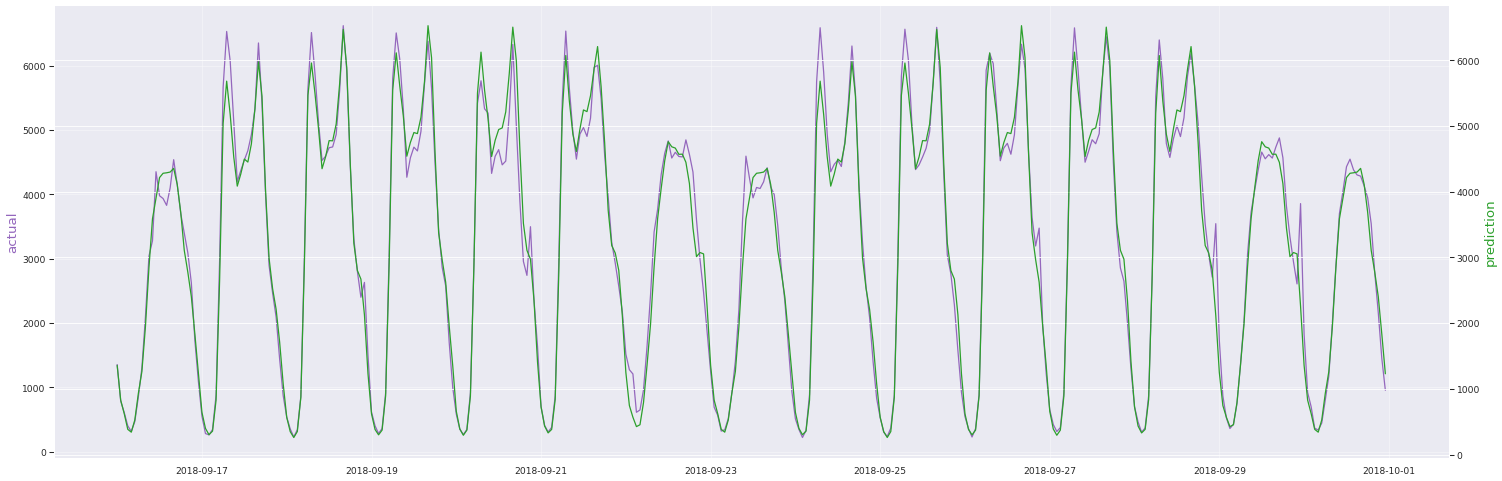

In [78]:
#baseline predictions visualisation

fig, ax1 = plt.subplots(1,1,figsize=(30,10), dpi= 60)
ax1.plot(predictions_baseline.datetime, predictions_baseline.traffic_volume, color='tab:purple')

ax2 = ax1.twinx()
ax2.plot(predictions_baseline.datetime, predictions_baseline.traffic_volume_predicted, color='tab:green')

ax1.set_ylabel('actual', color='tab:purple', fontsize=16)
ax1.grid(alpha=.4)

ax2.set_ylabel('prediction', color='tab:green', fontsize=16)

plt.show()  

LINEAR REGRESSION FORECAST

In [79]:
#get predictions

lr = LinearRegression()
lr.fit(X_train_sc, y_train)

predictions_linear = lr.predict(X_test_sc)

In [80]:
#get quality metrics

measured_metrics["linear"] = dataframe_metrics(y_test, predictions_linear)
measured_metrics

,error_type,baseline,linear
0,MAE,199.443901,312.433380
1,MSE,86759.407730,197657.270472
2,RMSE,294.549500,444.586629
3,R2,0.977096,0.947819
4,MAPE,7.761821,15.718123


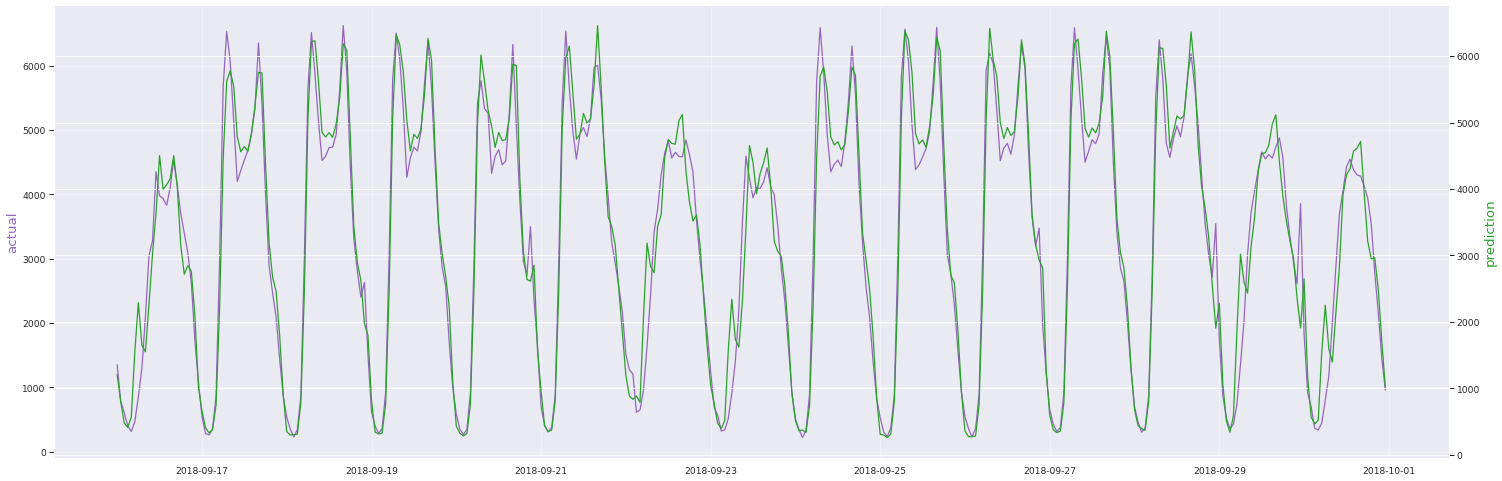

In [81]:
#linear predictions visualisation

fig, ax1 = plt.subplots(1,1,figsize=(30,10), dpi= 60)
ax1.plot(X_test.reset_index().datetime, y_test, color='tab:purple')

ax2 = ax1.twinx()
ax2.plot(X_test.reset_index().datetime, predictions_linear, color='tab:green')

ax1.set_ylabel('actual', color='tab:purple', fontsize=16)
ax1.grid(alpha=.4)

ax2.set_ylabel('prediction', color='tab:green', fontsize=16)

plt.show() 

LASSO REGRESSION FORECAST

In [82]:
#get predictions

tscv = TimeSeriesSplit(n_splits=5)

lasso = LassoCV(cv=tscv, eps=0.01, alphas=np.linspace(5, 10))
lasso.fit(X_train_sc, y_train)

predictions_lasso = ridge.predict(X_test_sc)

In [83]:
#get quality metrics

measured_metrics["lasso"] = dataframe_metrics(y_test, predictions_lasso)
measured_metrics

,error_type,baseline,linear,lasso
0,MAE,199.443901,312.433380,312.092312
1,MSE,86759.407730,197657.270472,197438.405039
2,RMSE,294.549500,444.586629,444.340416
3,R2,0.977096,0.947819,0.947876
4,MAPE,7.761821,15.718123,16.015014


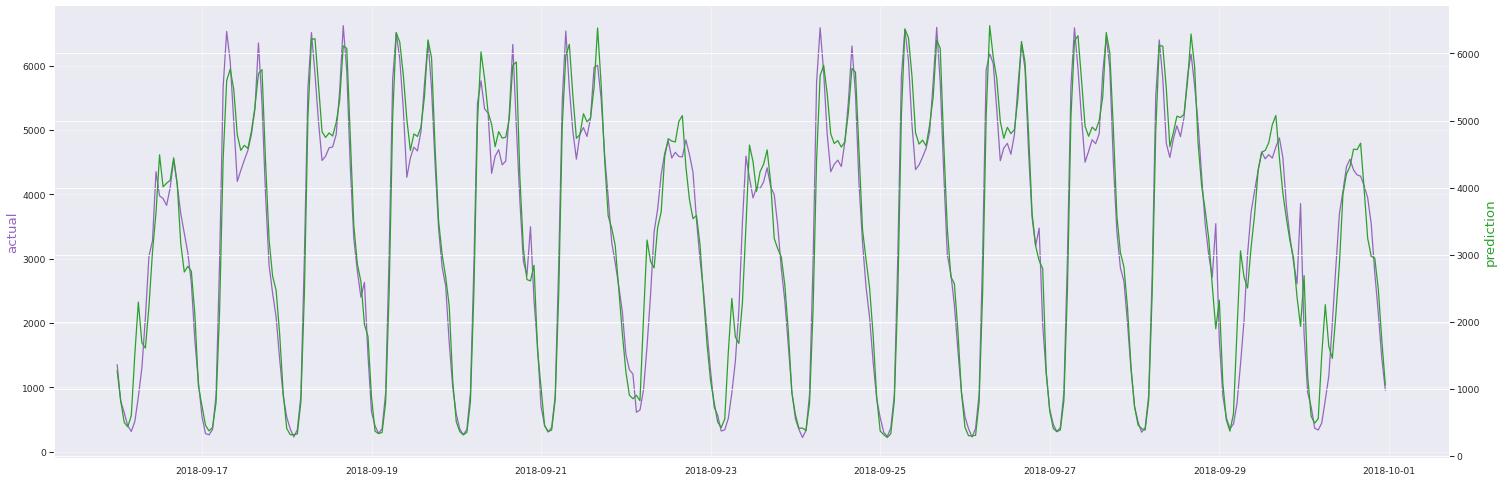

In [84]:
#lasso predictions visualisation

fig, ax1 = plt.subplots(1,1,figsize=(30,10), dpi= 60)
ax1.plot(X_test.reset_index().datetime, y_test, color='tab:purple')

ax2 = ax1.twinx()
ax2.plot(X_test.reset_index().datetime, predictions_lasso, color='tab:green')

ax1.set_ylabel('actual', color='tab:purple', fontsize=16)
ax1.grid(alpha=.4)

ax2.set_ylabel('prediction', color='tab:green', fontsize=16)

plt.show() 

GluonTS FORECAST

In [85]:
#split train and test

data['timestamp'] = data.index.astype('int64')
data_train_glts = ListDataset([{"start": data.index[0], "target": data.traffic_volume[:dt_train_test_limit]}],freq = "1h")
data_test_glts = ListDataset([{"start": data.index[0], "target": data.traffic_volume[:dt_train_test_limit]}],freq = "1h")

In [86]:
#train model

estimator_glts = DeepAREstimator(freq="1H", prediction_length=360, trainer=Trainer(epochs=20))
predictor_glts = estimator_glts.train(training_data=data_train_glts)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:25<00:00,  1.94it/s, epoch=20/20, avg_epoch_loss=6.6]


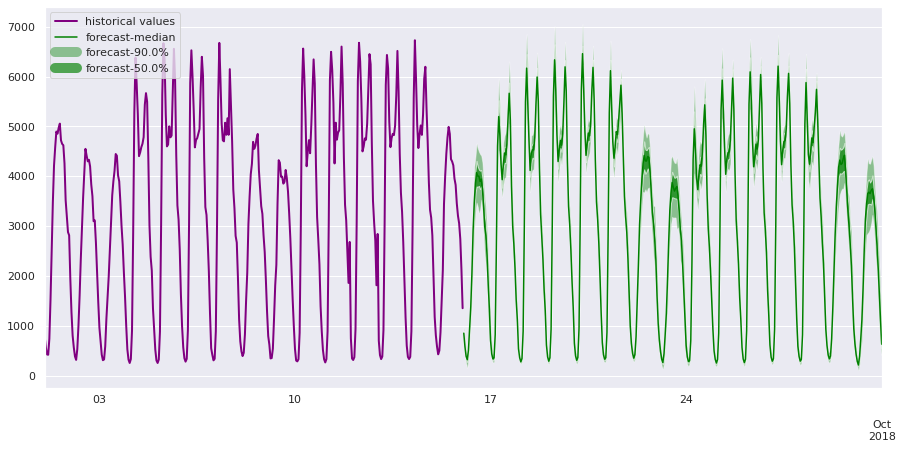

In [87]:
#GluonTS predictions visualisation - train and forecast

for test_entry_glts, predictions_glts_f in zip(data_test_glts, predictor_glts.predict(data_test_glts)):
    to_pandas(test_entry_glts)[-360:].plot(color='purple', linewidth=2, figsize=(15, 7), label="historical values")
    predictions_glts_f.plot(color='green', prediction_intervals=[50.0, 90.0], label="forecast")
    
plt.legend(loc='upper left')
plt.grid(axis='x')

In [88]:
#get quality metrics

predictions_glts = pd.DataFrame(predictions_glts_f.samples).median()

measured_metrics["GluonTS"] = dataframe_metrics(y_test, predictions_glts)
measured_metrics

,error_type,baseline,linear,lasso,GluonTS
0,MAE,199.443901,312.433380,312.092312,661.632550
1,MSE,86759.407730,197657.270472,197438.405039,779683.373790
2,RMSE,294.549500,444.586629,444.340416,882.996814
3,R2,0.977096,0.947819,0.947876,0.794164
4,MAPE,7.761821,15.718123,16.015014,32.376584


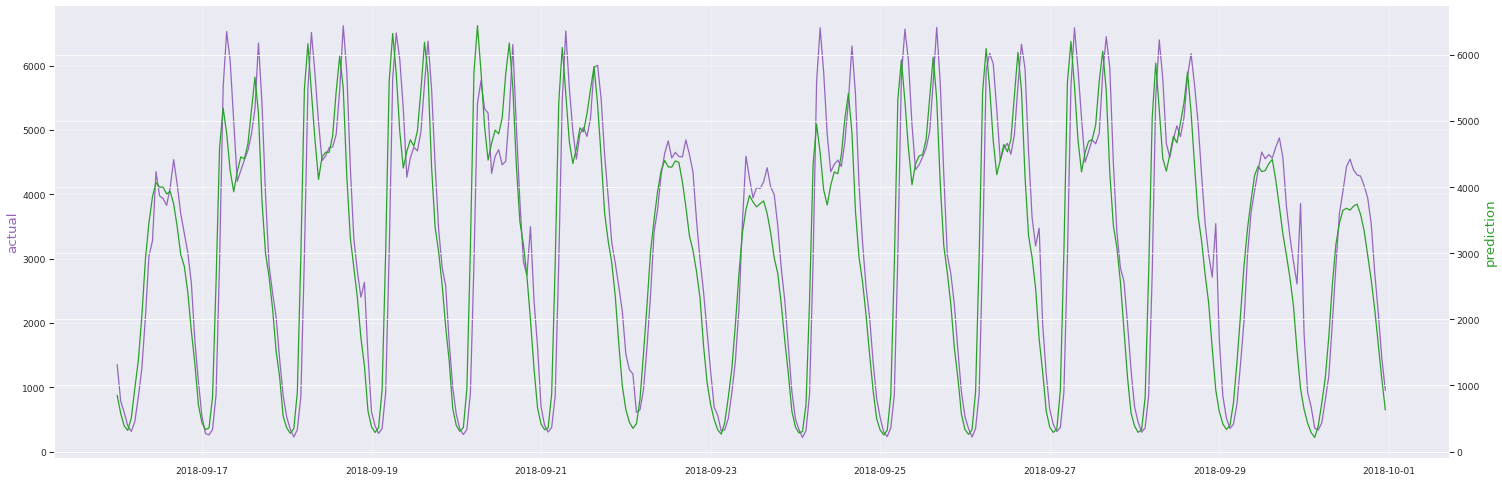

In [89]:
#GluonTS predictions visualisation - test and forecast

fig, ax1 = plt.subplots(1,1,figsize=(30,10), dpi= 60)
ax1.plot(X_test.reset_index().datetime, y_test, color='tab:purple')

ax2 = ax1.twinx()
ax2.plot(X_test.reset_index().datetime, predictions_glts, color='tab:green')

ax1.set_ylabel('actual', color='tab:purple', fontsize=16)
ax1.grid(alpha=.4)

ax2.set_ylabel('prediction', color='tab:green', fontsize=16)

plt.show() 

SARIMA

In [90]:
#train model

p = 4
d = 1
q = 4

P = 2
D = 1
Q = 1
s = 24

sarima = sm.tsa.statespace.SARIMAX(data_train.traffic_volume, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()

In [91]:
#get quality metrics

forecast_sarima = sarima.get_forecast(steps=360)
predictions_sarima = forecast_sarima.predicted_mean

measured_metrics["SARIMA"] = dataframe_metrics(y_test, predictions_sarima)
measured_metrics

,error_type,baseline,linear,lasso,GluonTS,SARIMA
0,MAE,199.443901,312.433380,312.092312,661.632550,566.649388
1,MSE,86759.407730,197657.270472,197438.405039,779683.373790,715434.230743
2,RMSE,294.549500,444.586629,444.340416,882.996814,845.833453
3,R2,0.977096,0.947819,0.947876,0.794164,0.811125
4,MAPE,7.761821,15.718123,16.015014,32.376584,30.688739


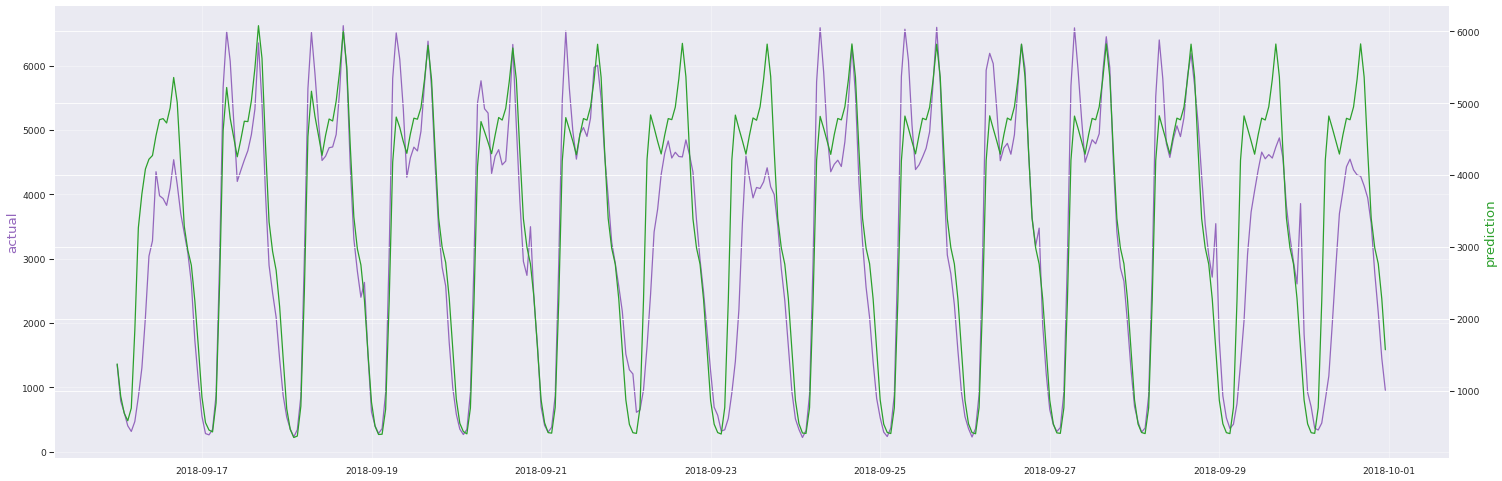

In [92]:
#SARIMA predictions visualisation

fig, ax1 = plt.subplots(1,1,figsize=(30,10), dpi= 60)
ax1.plot(X_test.reset_index().datetime, y_test, color='tab:purple')

ax2 = ax1.twinx()
ax2.plot(X_test.reset_index().datetime, predictions_sarima, color='tab:green')

ax1.set_ylabel('actual', color='tab:purple', fontsize=16)
ax1.grid(alpha=.4)

ax2.set_ylabel('prediction', color='tab:green', fontsize=16)

plt.show() 